### Kütüphaneleri import ederek başlayalım:

In [2]:
import tensorflow as tf

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
### Eğer Google Colab üzerinden çalışacaksanız, yorum satırlarındaki kodları çalıştırabilirsiniz.  ###

#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Veriyi inceleyelim:

In [4]:
#Yukarıda belirttiğim gibi, Colab üzerinde çalışacaksanız, buradaki yorum satırını kaldırıp çalıştırmalısınız.

#data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/emotionDetect-Github/Data/fer2013.csv")
data = pd.read_csv("Data/fer2013.csv")
data.shape

(35887, 3)

In [5]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
data["Usage"].value_counts()

# Training: modeli eğiteceğimiz veri.
# PrivateTest: modeli test edeceğimiz veri.
# PublicTest: en sonda başarı sonucu elde edeceğimiz veri.

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Eğitim Verisi için Ön İşleme

In [7]:
#np.unique(data["Usage"].values.ravel()) #burası data flatten hale getiriyor yani tek array. reshape(-1) gibi.
print("Train Dataset Count: %d"%(len(data[data.Usage == "Training"])))

Train Dataset Count: 28709


In [8]:
train_data = data[data.Usage == "Training"] # Sadece eğitim örneklerini train_data değişkenine atadık.

In [9]:
# data içinde pixeller arasındaki boşluklardan ayırarak tekrar list yapacağız. tek sıra halinde verilmişti.

train_pixels = train_data.pixels.str.split(" ").tolist()
train_pixels = pd.DataFrame(train_pixels, dtype=int)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)
print(train_images.shape)
#her bir satır bir image. 48x48=2304 pixel değeri, her satır için.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [11]:
def show(img):
  show_image = img.reshape(48,48)
  plt.axis("off")
  plt.imshow(show_image, cmap="gray")
  
#görüntüyü 48*48 şekilde göstermek için function.

#### Eğitim verisinden bir örnek görelim:

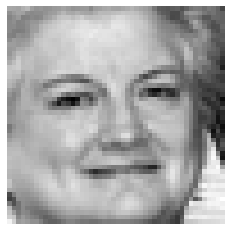

In [12]:
show(train_images[100])

In [13]:
# eğitim kümesinde kaç sınıf var buna bakalım.

train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print("Number of emotions: %d"%train_labels_count) # ya da (len(np.unique(train_data["emotion"]))). ama daha sonra bunu kullanacağız.

Number of emotions: 7


In [14]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

#her bir görüntü için 0'lardan oluşan 7 tane sınıf açtık

In [15]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)

print(y_train.shape)
#28709 örnek için 7 sınıf.

(28709, 7)


### PublicTest Verisi için Ön İşleme

In [16]:
#np.unique(data["Usage"].values.ravel()) #burası data flatten hale getiriyor yani tek array. reshape(-1) gibi.
print("Public Test Count: %d"%(len(data[data.Usage == "PublicTest"])))

Public Test Count: 3589


In [17]:
# Şimdi aynı şekilde test işlemi için ön işleme gerçekleştirelim.

test_data = data[data.Usage == "PublicTest"]
test_pixels = test_data.pixels.str.split(" ").tolist()

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


(3589, 2304)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


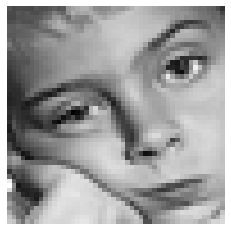

In [18]:
show(test_images[44])

In [19]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]
print("Number of emotions: %d"%test_labels_count)

Number of emotions: 7


In [20]:
y_test = dense_to_one_hot(test_labels_flat, test_labels_count)
y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


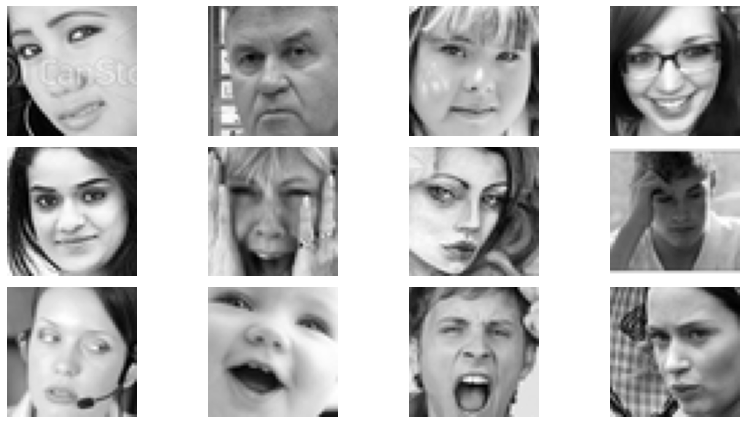

In [21]:
# Test kümesinden örnekler:

plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3,4,i)
  plt.axis('off')

  show(test_images[i])

plt.tight_layout()
plt.show()

In [22]:
# CNN Modeli Tanımlama

model = Sequential() #bir dizi, boş bir hacim tanımlayacağız.

#1.Katman: 3 filtreden oluşan bir conv katmanı.
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# 2.Katman
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.4)) #%40ını unutturuyoruz.(Nöron silme)

# 3.Katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4.Katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))


#5.Katman
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.4)) #%40ını unutturuyoruz.(Nöron silme)

#Tam Bağlantı Katmanı
model.add(Flatten()) # Flatten ile matrisi vektör haline çeviriyoruz.
model.add(Dense(128)) # 128lik dense ile tam bağlantı işlemi gerçekleştiriyoruz.
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

#Çıkış Katmanı
model.add(Dense(7)) #Zira 7 tane duygu tanımımız var.
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"]) #optimizasyon ve başarı hesaplama metrikleri
model.summary() #model özeti görselleştirme



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [23]:
# eğitim ve test datasının eleman sayısı, yükseklik, genişlik ve kanal sayılarını görelim.

x_train = train_images.reshape(-1,48,48,1)
x_test = test_images.reshape(-1,48,48,1)

print(x_train.shape)
print(x_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)


In [24]:
# eğitim ve test datasının eleman ve sınıf sayısı.

print(y_train.shape)
print(y_test.shape)

(28709, 7)
(3589, 7)


### Model Eğitimi:

In [25]:
# ŞİMDİ EĞİTİME GEÇELİM:

#checkpointer = ModelCheckpoint(filepath="/content/gdrive/My Drive/Colab Notebooks/emotionDetect-Github/Data/emotionDetect_model.h5", verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath="Data/emotionDetect_model.h5", verbose=1, save_best_only=True) # Colab üzerinde çalışacaksanız, üstteki kodu kullanmalısınız.
# şu dosyaya, öğrendiğim modelin ağırlıkları kaydedilsin. yani modelim kaydedilsin ki ileride tekrar train olmadan kullanabileyim.


epoch = 15
batchSize = 100

#modeli fit edelim:
hist = model.fit(x_train, y_train, epochs=epoch, shuffle=True, batch_size=batchSize, validation_data=(x_test,y_test), callbacks=[checkpointer], verbose=2)
#callbackteki checkpointer ile, validasyonun iyi olduğu değerleri (her bir epochta) daha iyi olan edğerleri kaydetmiş oluyoruz.

#modeli json olarak kaydedlim.
model_json = model.to_json()
with open("Data/emotionDetect_model.json", "w") as json_file:
  json_file.write(model_json)

Epoch 1/15

Epoch 1: val_loss improved from inf to 1.49110, saving model to /content/gdrive/My Drive/Colab Notebooks/emotionDetect-Github/Data/emotionDetect_model.h5
288/288 - 19s - loss: 1.8025 - accuracy: 0.3193 - val_loss: 1.4911 - val_accuracy: 0.4335 - 19s/epoch - 66ms/step
Epoch 2/15

Epoch 2: val_loss improved from 1.49110 to 1.40766, saving model to /content/gdrive/My Drive/Colab Notebooks/emotionDetect-Github/Data/emotionDetect_model.h5
288/288 - 8s - loss: 1.4935 - accuracy: 0.4229 - val_loss: 1.4077 - val_accuracy: 0.4528 - 8s/epoch - 29ms/step
Epoch 3/15

Epoch 3: val_loss improved from 1.40766 to 1.26683, saving model to /content/gdrive/My Drive/Colab Notebooks/emotionDetect-Github/Data/emotionDetect_model.h5
288/288 - 8s - loss: 1.3629 - accuracy: 0.4753 - val_loss: 1.2668 - val_accuracy: 0.5227 - 8s/epoch - 29ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 1.26683
288/288 - 8s - loss: 1.2915 - accuracy: 0.5037 - val_loss: 1.2702 - val_accuracy: 0.5171 - 8s/epo

### Loss ve Accuracy değerlerini görelim:

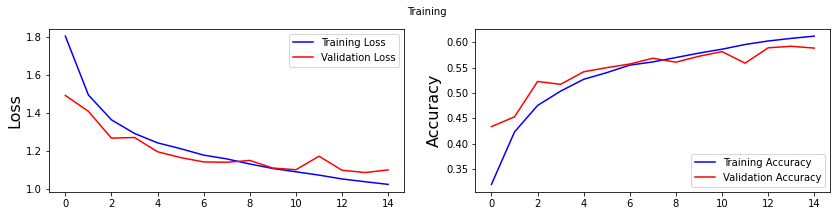

In [26]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Training', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### PrivateTest kısmına geçelim:

In [27]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [28]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [29]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1) #48*48 lik tek kanallı şekilde düzenledik.
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [30]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerinde doğruluk başarımı:", score)

PrivateTest üzerinde doğruluk başarımı: [1.0476082563400269, 0.6023961901664734]


### Modelin farklı görseller üzerinde başarısına bakalım:

In [31]:
# farklı görsellerle test edelim:

from keras.models import load_model
from keras.preprocessing import image
from PIL import Image

In [32]:
# kaydettiğimiz modeldeki ağırlıkarı kullanalım:

#saved_model = load_model("/content/gdrive/My Drive/Colab Notebooks/emotionDetect-Github/Data/emotionDetect_model.h5")
saved_model = load_model("Data/emotionDetect_model.h5") # Colab üzerinde çalışacaksanız, üstteki kodu kullanmalısınız.

In [46]:
# image_path = "/content/gdrive/My Drive/Colab Notebooks/emotionDetect-Github/Data/images/baby_cry.jpeg"
image_path = "Data/images/baby_cry.jpeg" # Colab üzerinde çalışacaksanız, üstteki kodu kullanmalısınız.

test_image_orj = image.load_img(image_path) #orjinal renkli görüntü. henüz işlem yapılmadı.
test_image = image.load_img(image_path, target_size=(48,48), color_mode="grayscale") #bu da işlem yapacağımız şekli. gri olarak.
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = np.vstack([test_image])

result = saved_model.predict(test_image, batch_size=1)
print(result)

[[0.08955687 0.00055655 0.15085377 0.01769028 0.49120113 0.10893472
  0.14120665]]


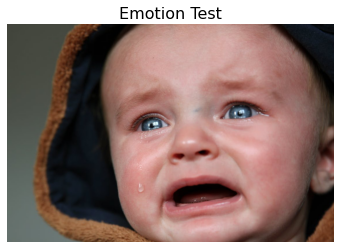

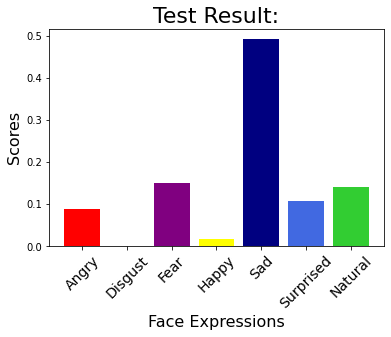

In [47]:
# bunun görselleştirilmesi:

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprised", "Natural"]
color_list = ["red", "green", "purple", "yellow", "navy", "royalblue", "limegreen"]
x_axis = np.arange(len(class_names))

plt.imshow(test_image_orj)
plt.title("Emotion Test", fontsize=16)
plt.axis("off")
plt.show()

#sonuçları gösterelim:
for i in range(len(class_names)):
  plt.bar(x_axis[i], result[0][i], color=color_list[i])

plt.title("Test Result:", fontsize=22)
plt.xlabel("Face Expressions", fontsize=16)
plt.ylabel("Scores", fontsize=16)
plt.xticks(x_axis, class_names, rotation=45, fontsize=14)
plt.show()


In [38]:
def detectEmotion(imagePath):
  test_image_orj = image.load_img(imagePath) #orjinal renkli görüntü. henüz işlem yapılmadı.
  test_image = image.load_img(imagePath, target_size=(48,48), color_mode="grayscale") #bu da işlem yapacağımız şekli. gri olarak.
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  test_image = np.vstack([test_image])

  result = saved_model.predict(test_image, batch_size=1)

  class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprised", "Natural"]
  color_list = ["red", "green", "purple", "yellow", "navy", "royalblue", "limegreen"]
  x_axis = np.arange(len(class_names))

  plt.imshow(test_image_orj)
  plt.title("Emotion Test", fontsize=16)
  plt.axis("off")
  plt.show()

  #sonuçları gösterelim:
  for i in range(len(class_names)):
    plt.bar(x_axis[i], result[0][i], color=color_list[i])

  plt.title("Test Result:", fontsize=22)
  plt.xlabel("Face Expressions", fontsize=16)
  plt.ylabel("Scores", fontsize=16)
  plt.xticks(x_axis, class_names, rotation=45, fontsize=14)
  plt.show()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


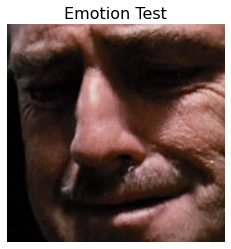

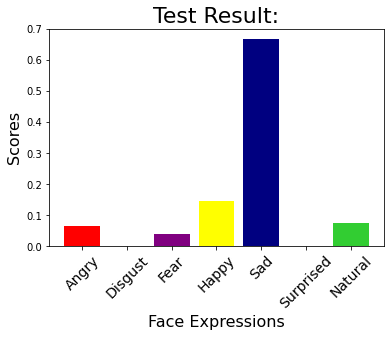

In [40]:
detectEmotion(imagePath="Data/images/brando.png")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


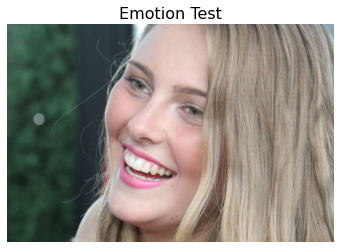

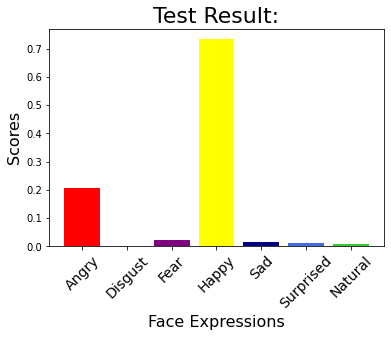

In [41]:
detectEmotion(imagePath="Data/images/face.jpeg")